In [18]:
import cv2
import numpy as np
import dask as d
import matplotlib.pyplot as plt
import time
import keras_tuner as kt
import random

In [2]:
from glob import glob
from tensorflow import test, device
# from tensorflow import keras 
from tensorflow.keras import backend, Input, Model, layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, MeanIoU
from tensorflow.keras.optimizers import RMSprop

In [3]:
from fl_tissue_model_tools import defs, models
import fl_tissue_model_tools.preprocessing as prep

In [4]:
data_root_path = "/nfs/stak/users/wigginno/hpc-share/data/branching_data"
# data_root_path = "./" # Mitchell

In [5]:
img_paths = sorted([fn.replace("\\", "/") for fn in glob(f"{data_root_path}/images/*.png")])
label_paths = sorted([fn.replace("\\", "/") for fn in glob(f"{data_root_path}/masks/*.png")])

In [6]:
len(label_paths)

5000

# Validate images match labels in order & count

In [7]:
def get_img_id(img_path):
    return img_path.split("/")[-1].split(".")[0]

In [8]:
assert(all([get_img_id(img_paths[i]) == get_img_id(label_paths[i]) for i in range(len(img_paths))]))

In [9]:
assert(len(img_paths) == len(label_paths))
print(len(img_paths))

5000


# Constants

In [10]:
rand_seed = 12345
batch_size = 32
img_shape = (128, 128)
# img_size = (160, 160)
# num_classes = 2
n_outputs = 1
rs = np.random.RandomState(seed=rand_seed)
# For collapsing mask into binary range
fg_vals = [1, 3]
bg_vals = [2]
cp_filepath = "oxford_pets_segmentation_best_weights.h5"
cls_thresh = 0.5
filter_counts_options = [
    (8, 16, 32, 64),
    (16, 32, 64, 128),
    (32, 64, 128, 256)
]

# Examine data

In [11]:
preview_idx = 10

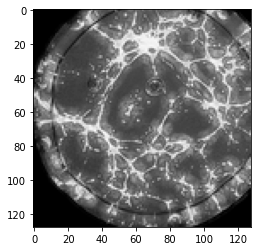

In [12]:
# img = cv2.imread(img_paths[preview_idx], cv2.IMREAD_GRAYSCALE)
img = np.expand_dims(np.array(load_img(img_paths[preview_idx], target_size=img_shape, color_mode="grayscale", interpolation="lanczos")), 2)
plt.imshow(img, cmap="gray")
plt.show()

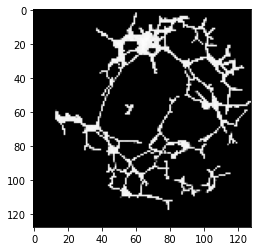

In [13]:
mask = np.expand_dims(
    np.array(load_img(label_paths[preview_idx], target_size=img_shape, color_mode="grayscale", interpolation="nearest")), 2
)
mask = prep.map2bin(mask, fg_vals, bg_vals)
plt.imshow(mask, cmap="gray")
plt.show()

In [14]:
np.unique(mask)

array([  0,   1,   4,   5,   6,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  19,  20,  21,  23,  24,  25,  26,  28,  29,  30,  31,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  55,  56,  57,  59,  60,  61,  63,
        64,  66,  67,  68,  69,  70,  72,  73,  74,  75,  77,  80,  81,
        82,  84,  85,  86,  87,  88,  89,  91,  93,  97,  99, 102, 103,
       105, 106, 110, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122,
       124, 128, 129, 130, 132, 133, 134, 136, 137, 139, 140, 142, 144,
       148, 151, 152, 153, 155, 160, 161, 162, 163, 167, 168, 171, 172,
       173, 174, 175, 178, 179, 181, 182, 183, 185, 186, 187, 189, 191,
       192, 196, 197, 199, 201, 206, 207, 208, 209, 211, 212, 213, 214,
       215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227,
       228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240,
       241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 25

# Data pipeline

In [15]:
def load_y(batch_label_paths, img_shape, fg_vals=fg_vals, bg_vals=bg_vals):
    # load the target images and condense the number of labels in the segmentation mask
    y = np.zeros((len(batch_label_paths),) + img_shape + (1,), dtype=np.uint8)
    for j, path in enumerate(batch_label_paths):
        # Use interpolation="nearest" to ensure mask is only valid bit values
        img = load_img(path, target_size=img_shape, color_mode="grayscale", interpolation="nearest")
        # add a third dimension to the array
        img = np.expand_dims(img, 2)
        # Collapse the mask from three labels to two labels
        img = prep.map2bin(img, fg_vals, bg_vals)
        y[j] = img
    return y


def load_x(batch_img_paths, img_shape, t_mean=0, t_std=1):
    # Load the input images and convert them to grayscale
    x = np.zeros((len(batch_img_paths),) + img_shape + (1,), dtype=np.float32)
    for j, path in enumerate(batch_img_paths):
        # Ensure best quality downsampling (interpolation methods overview: https://stackoverflow.com/a/44083113)
        img = load_img(path, target_size=img_shape, color_mode="grayscale", interpolation="lanczos")
        img = np.expand_dims(img, 2) # add a third dimension to the array
        x[j] = img
    return (x - t_mean) / t_std


class BinaryMaskSequence(Sequence):
    """Helper to iterate over the data"""
    
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, random_state, load_x, load_y, fg_val=1, bg_val=0, sample_weights=None, augmentation_function=None, dist_params=None):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.rs: np.random.RandomState = random_state
        self.load_x = load_x
        self.load_y = load_y
        self.fg_val = fg_val
        self.bg_val = bg_val
        self.sample_weights = sample_weights
        if sample_weights:
            self.fg_weight = sample_weights[self.fg_val]
            self.bg_weight = sample_weights[self.bg_val]
        self.dist_params = dist_params
        if dist_params:
            self.t_mean = dist_params["mean"]
            self.t_std = dist_params["std"]
            
        self.augmentation_function = augmentation_function

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def __getitem__(self, idx):
        """Returns the batch (input, target) at index `idx`"""
        # Image index, offset by batch
        i = idx * self.batch_size 
        
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        if self.dist_params:
            x, y = d.compute((d.delayed(self.load_x)(batch_input_img_paths, self.img_size, t_mean=self.t_mean, t_std=self.t_std), d.delayed(self.load_y)(batch_target_img_paths, self.img_size)))[0]
        else:
            x, y = d.compute((d.delayed(self.load_x)(batch_input_img_paths, self.img_size), d.delayed(self.load_y)(batch_target_img_paths, self.img_size)))[0]
        
        if self.augmentation_function != None:
            x, y = self.augmentation_function(x, y, self.rs)

        # If want to up/down-weight foreground/background pixel loss
        # This is good for images that tend to be imbalanced between foreground
        # and background pixel area.
        if self.sample_weights:
            batch_sample_weights = np.zeros(shape=y.shape)
            batch_sample_weights[y == self.fg_val] = self.fg_weight
            batch_sample_weights[y != self.fg_val] = self.bg_weight
            return x, y, batch_sample_weights
            
        return x, y

# Data generator demo

1.8200163841247559


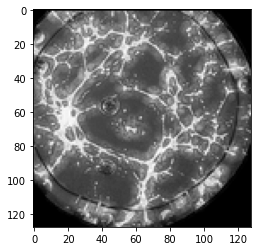

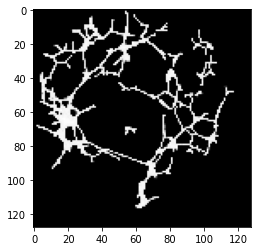

In [16]:
# pets_demo = data_prep.BinaryMaskSequence(batch_size, img_shape, img_paths, label_paths, rs, load_x, load_y, augmentation_function=augment_data)
pets_demo = BinaryMaskSequence(batch_size, img_shape, img_paths, label_paths, rs, load_x, load_y, augmentation_function=prep.augment_img_mask_pairs)
start = time.time()
X, y = pets_demo[1]
stop = time.time()
print(stop - start)
plt.imshow(X[1][:,:,0], cmap='gray')
plt.show()
plt.imshow(y[1][:,:,0], cmap='gray')
plt.show()

# Set up data generators

In [38]:
all_img_types = set(["".join(x.split("/")[-1].split("_")[0:2]) for x in img_paths])
branch_img_types = set([x for x in all_img_types if "branch" in x])
retinal_img_types = set([x for x in all_img_types if "retina" in x])
val_branch_types = set(random.sample(list(branch_img_types), 2))
val_retinal_types = set(random.sample(list(retinal_img_types), 8))
non_val_branch_types = branch_img_types - val_branch_types
non_val_retinal_types = retinal_img_types - val_retinal_types
test_branch_types = set(random.sample(list(non_val_branch_types), 2))
test_retinal_types = set(random.sample(list(non_val_retinal_types), 8))
train_branch_types = non_val_branch_types - test_branch_types
train_retinal_types = non_val_retinal_types - test_retinal_types
train_img_paths_branch = [x for x in img_paths if "".join(x.split("/")[-1].split("_")[0:2]) in train_branch_types]
val_img_paths_branch = [x for x in img_paths if "".join(x.split("/")[-1].split("_")[0:2]) in val_branch_types]
test_img_paths_branch = [x for x in img_paths if "".join(x.split("/")[-1].split("_")[0:2]) in test_branch_types]
train_img_paths_retinal = [x for x in img_paths if "".join(x.split("/")[-1].split("_")[0:2]) in train_retinal_types]
val_img_paths_retinal = [x for x in img_paths if "".join(x.split("/")[-1].split("_")[0:2]) in val_retinal_types]
test_img_paths_retinal = [x for x in img_paths if "".join(x.split("/")[-1].split("_")[0:2]) in test_retinal_types]

In [39]:
len(train_img_paths_retinal)/2500

0.8128

In [40]:
len(val_img_paths_retinal)/2500

0.0908

In [41]:
len(test_img_paths_retinal)/2500

0.0964

In [42]:
len(train_img_paths_branch)/2500

0.6388

In [43]:
len(val_img_paths_branch)/2500

0.1864

In [44]:
len(test_img_paths_branch)/2500

0.1748

In [63]:
train_img_paths = list(set(train_img_paths_branch).union(set(train_img_paths_retinal)))
train_label_paths = [x.replace("images", "masks") for x in train_img_paths]
val_img_paths = list(set(val_img_paths_branch).union(set(val_img_paths_retinal)))
val_label_paths = [x.replace("images", "masks") for x in val_img_paths]
test_img_paths = list(set(test_img_paths_branch).union(set(test_img_paths_retinal)))
test_label_paths = [x.replace("images", "masks") for x in test_img_paths]

In [64]:
len(train_img_paths)

3629

In [65]:
len(train_label_paths)

3629

In [66]:
len(val_img_paths)

693

In [67]:
len(val_label_paths)

693

In [68]:
len(test_img_paths)

678

In [69]:
len(test_label_paths)

678

In [70]:
"""
n_val = int(len(img_types) * 0.2)   # 2 from branching, 8 from retinal
n_test = int(len(img_types) * 0.2)  # 2 from branching, 8 from retinal
# Shuffle data
data_idx = np.array(range(len(img_types)))
rs.shuffle(data_idx)
"""

'\nn_val = int(len(img_types) * 0.2)   # 2 from branching, 8 from retinal\nn_test = int(len(img_types) * 0.2)  # 2 from branching, 8 from retinal\n# Shuffle data\ndata_idx = np.array(range(len(img_types)))\nrs.shuffle(data_idx)\n'

In [71]:
"""
train_img_paths = img_paths[: -(n_val + n_test)]
train_label_paths = label_paths[: -(n_val + n_test)]

val_img_paths = img_paths[-(n_val + n_test): -n_test]
val_label_paths = label_paths[-(n_val + n_test): -n_test]

test_img_paths = img_paths[-n_test:]
test_label_paths = label_paths[-n_test:]
"""

'\ntrain_img_paths = img_paths[: -(n_val + n_test)]\ntrain_label_paths = label_paths[: -(n_val + n_test)]\n\nval_img_paths = img_paths[-(n_val + n_test): -n_test]\nval_label_paths = label_paths[-(n_val + n_test): -n_test]\n\ntest_img_paths = img_paths[-n_test:]\ntest_label_paths = label_paths[-n_test:]\n'

## Compute sample weights & mean/std for training data

In [72]:
y_train_labels = load_y(train_label_paths, img_shape)

In [73]:
n_fg = np.sum(y_train_labels == 1)
n_bg = np.sum(y_train_labels == 0)
fg_weight = float(n_fg + n_bg) / (2.0 * n_fg)
bg_weight = float(n_fg + n_bg) / (2.0 * n_bg)
sample_weights = {0: bg_weight, 1: fg_weight}
sample_weights

{0: 0.5007143124695796, 1: 350.48689039702265}

In [74]:
x_train_imgs = load_x(train_img_paths, img_shape)

In [75]:
d_params = {"mean": np.mean(x_train_imgs), "std": np.std(x_train_imgs)}
d_params

{'mean': 115.844154, 'std': 59.788044}

In [76]:
train_gen = BinaryMaskSequence(batch_size, img_shape, train_img_paths, train_label_paths, rs, load_x, load_y, augmentation_function=prep.augment_img_mask_pairs, sample_weights=sample_weights, dist_params=d_params)
val_gen = BinaryMaskSequence(batch_size, img_shape, val_img_paths, val_label_paths, rs, load_x, load_y, augmentation_function=prep.augment_img_mask_pairs, sample_weights=sample_weights, dist_params=d_params)
# No augmentation for test_gen
test_gen = BinaryMaskSequence(batch_size, img_shape, test_img_paths, test_label_paths, rs, load_x, load_y, dist_params=d_params)

# Run grid search

In [77]:
backend.clear_session()

In [78]:
# tell tf to use the gpu
# import tensorflow as tf
device(test.gpu_device_name())

2022-09-09 00:29:27.104965: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 43523 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:81:00.0, compute capability: 8.6


In [79]:
test.gpu_device_name()

2022-09-09 00:29:27.125326: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 43523 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:81:00.0, compute capability: 8.6


'/device:GPU:0'

In [80]:
backend.clear_session()

In [81]:
gs = models.UNetXceptionGridSearch(
    "oxford_pets_grid_search",
    filter_counts_options,
    n_outputs,
    img_shape,
    optimizer=RMSprop(),
    loss=BinaryCrossentropy(),
    metrics=[models.mean_iou_coef_factory(thresh=cls_thresh)],
    output_act="sigmoid"
)

In [82]:
n_epochs = 5
gs.search(
    "val_mean_iou_coef",
    "max",
    train_gen,
    search_verbose=True,
    validation_data=val_gen,
    epochs=n_epochs
)

Testing filter counts: (8, 16, 32, 64)
Epoch 1/5
113/113 [==============================] - 252s 2s/step - loss: -5445451.0000 - mean_iou_coef: 17.0447 - val_loss: -11905934.0000 - val_mean_iou_coef: 19.2392
Epoch 2/5
113/113 [==============================] - 210s 2s/step - loss: -529591840.0000 - mean_iou_coef: 17.2855 - val_loss: -1311905920.0000 - val_mean_iou_coef: 19.2397
Epoch 3/5
113/113 [==============================] - 210s 2s/step - loss: -9758083072.0000 - mean_iou_coef: 17.2853 - val_loss: -30814138368.0000 - val_mean_iou_coef: 19.2390
Epoch 4/5
113/113 [==============================] - 211s 2s/step - loss: -81419403264.0000 - mean_iou_coef: 17.2863 - val_loss: -223871123456.0000 - val_mean_iou_coef: 19.2390
Epoch 5/5
113/113 [==============================] - 211s 2s/step - loss: -426019979264.0000 - mean_iou_coef: 17.2855 - val_loss: -1046770745344.0000 - val_mean_iou_coef: 19.2396
Best objective value observed: 19.23972511291504
Best objective value observed on epoch:

In [83]:
gs.best_filter_counts

(16, 32, 64, 128)

In [84]:
gs.best_score

19.241426467895508

In [85]:
gs.best_score_idx

1

# Load best weights

In [86]:
best_model = gs.get_best_model()

In [87]:
test_ex_batch = 10

In [88]:
test_example_x, test_example_y = test_gen[test_ex_batch]

In [89]:
test_preds = best_model.predict(test_example_x)

1/1 [==============================] - 0s 363ms/step


In [90]:
np.any(np.array([float(models.mean_iou_coef_factory(thresh=cls_thresh)(np.expand_dims(test_example_y[i], axis=0), np.expand_dims(test_preds[i], axis=0))) for i in range(len(test_preds))]) > 1)

True

In [91]:
test_ex_idx = 21
test_ex_img = test_example_x[test_ex_idx]
test_ex_pred = test_preds[test_ex_idx]
test_ex_true = test_example_y[test_ex_idx]

In [92]:
float(models.mean_iou_coef_factory(thresh=cls_thresh)(np.expand_dims(test_example_y[test_ex_idx], axis=0), np.expand_dims(test_preds[test_ex_idx], axis=0)))

18.377906799316406

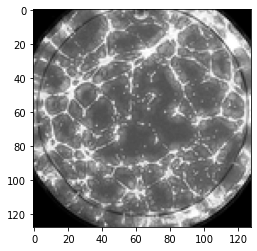

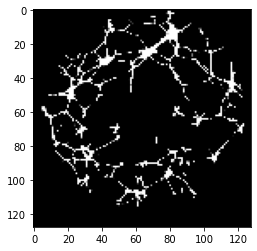

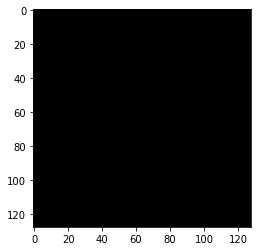

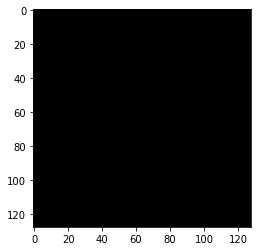

In [93]:
# plt.imshow(test_ex_img, cmap="gray", vmin=defs.GS_MIN, vmax=defs.GS_MAX)
# plt.show()
# plt.imshow(test_ex_true * 255, cmap="gray", vmin=defs.GS_MIN, vmax=defs.GS_MAX)
# plt.show()
# plt.imshow(test_ex_pred * 255, cmap="gray", vmin=defs.GS_MIN, vmax=defs.GS_MAX)
# plt.show()
# plt.imshow((np.greater(test_ex_pred, cls_thresh)).astype(np.uint8) * 255, cmap="gray", vmin=defs.GS_MIN, vmax=defs.GS_MAX)
# plt.show()

plt.imshow(test_ex_img, cmap="gray")
plt.show()
plt.imshow(test_ex_true, cmap="gray")
plt.show()
plt.imshow(test_ex_pred, cmap="gray")
plt.show()
plt.imshow(np.greater(test_ex_pred, cls_thresh), cmap="gray")
plt.show()